# Explore the data

### Import packages

In [1]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from scipy.io import loadmat
from scipy import interpolate
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

Using TensorFlow backend.


### Loading Images 

In [65]:
images = loadmat("H:/Project Files/1_Heart_segmentation/Dataset/york/Data/sol_yxzt_pat18.mat")
images = images['sol_yxzt']

### Extract the data as a numpy array

In [66]:
height, width, depth, channels = images.shape
print('height {}, width {}, depth {}, channels {}'.format(height, width, depth, channels))

height 256, width 256, depth 11, channels 20


### Visualize the data

Plotting Layer 0 Channel 2 of Image


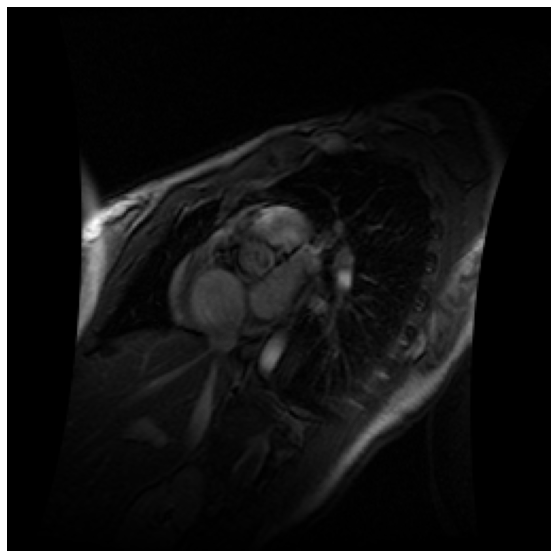

In [5]:
maxval = depth
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 2
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.figure(figsize=(20, 10))
plt.imshow(images[:, :, i, channel], cmap='gray')
plt.axis('off');

### Interactive exploration

In [7]:
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(images[:, :, layer, channel], cmap='gray')
    plt.title('Explore Layers of Cardiac MRI', fontsize=20)
    plt.axis('off')
    return layer
interact(explore_3dimage, layer=(0, depth-1));

interactive(children=(IntSlider(value=5, description='layer', max=10), Output()), _dom_classes=('widget-intera…

In [8]:
def explore_3dimage(channel):
    plt.figure(figsize=(20, 10))
    layer = 6
    plt.imshow(images[:, :, layer, channel], cmap='gray')
    plt.title('Explore channels of Cardiac MRI', fontsize=20)
    plt.axis('off')
    return layer
interact(explore_3dimage, channel=(0, channels-1));

interactive(children=(IntSlider(value=9, description='channel', max=19), Output()), _dom_classes=('widget-inte…

### Explore the data labels

In [67]:
label_array = loadmat('H:/Project Files/1_Heart_segmentation/Dataset/york/segmentation/manual_seg_32points_pat18.mat')

In [68]:
segs = label_array['manual_seg_32points']
segs.shape

(11, 20)

In [71]:
segs

array([[array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]])],
       [array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]]), array([[-99999]]),
        array([[-99999]]), array([[-99999]])],
       [array([[119.95365093, 123.03172195],
       [116.77041994, 123.85703628],
       [114.21988014, 125.90010823],
       

In [73]:
dim = (256,256)
def show_segs_all(segs,images):    
    s_zval,s_tval = segs.shape 
    i_yval,i_xval,i_zval,i_tval = images.shape
    if(s_zval != i_zval or s_tval != i_tval):
        print('Shape Error!')
    for z_pos in range(0,2):
        for time_pos in range(0,2):
            picture  = cv2.resize(images[:,:,z_pos,time_pos], dim, interpolation = cv2.INTER_AREA)


            temp = segs[z_pos,time_pos]
            sx, sy = temp.shape
            if temp[0][0] != -99999:
                plt.figure(figsize=(10, 5))
                plt.imshow(picture, cmap='gray')
                half = int((sx-1)/2)
                pointsXendo = temp[0:half,0]
                pointsYendo = temp[0:half,1]

                pointsXepi = temp[half+1:2*half+1,0]
                pointsYepi = temp[half+1:2*half+1,1]

                stemp1 = pointsXendo.shape[0]

                a1 = np.linspace(0, 10, num=stemp1, retstep=False)
                sampling_data_endo=np.zeros((2000,2))
                sampling_data_epi=np.zeros((2000,2))
                b1 = np.linspace(0, 10, num=2000, retstep=False)

                sampling_data_endo[:,0] = interpolate.PchipInterpolator(a1, pointsXendo)(b1)
                sampling_data_endo[:,1] = interpolate.PchipInterpolator(a1, pointsYendo)(b1)
                sampling_data_epi[:,0] = interpolate.PchipInterpolator(a1, pointsXepi)(b1)
                sampling_data_epi[:,1] = interpolate.PchipInterpolator(a1, pointsYepi)(b1)

                dots = sampling_data_endo
                last_x_points = []
                last_x_points.append(dots[0,0])
                last_x_points.append(dots[1999,0])
                
                last_y_points = []
                last_y_points.append(dots[0,1])
                last_y_points.append(dots[1999,1])
                
                plt.plot(dots[:,0],dots[:,1],color='green')
                plt.plot(last_x_points,last_y_points,color='green')
               

                dots = sampling_data_epi
                last_x_points = []
                last_x_points.append(dots[0,0])
                last_x_points.append(dots[1999,0])
                
                last_y_points = []
                last_y_points.append(dots[0,1])
                last_y_points.append(dots[1999,1])
                
                plt.plot(dots[:,0],dots[:,1],color='red')
                plt.plot(last_x_points,last_y_points,color='red')
show_segs_all(segs,images)

### Creating Dataframe and saving images

In [14]:
image_path = 'H:/Project Files/1_Heart_segmentation/Dataset/york/Data/'
label_path = 'H:/Project Files/1_Heart_segmentation/Dataset/york/segmentation/'

#### Saving Image

In [16]:
seg_dict = {}
name_list = []
endoX = []
endoY = []
epiX = []
epiY = []
def save_image_seg(index,segs,images,dest_path):    
    s_zval,s_tval = segs.shape 
    i_yval,i_xval,i_zval,i_tval = images.shape
    if(s_zval != i_zval or s_tval != i_tval):
        print('Shape Error!')
        return 

    for z_pos in range(0,i_zval):
        for time_pos in range(0,20):
            picture  = cv2.resize(images[:,:,z_pos,time_pos], dim, interpolation = cv2.INTER_AREA)


            temp = segs[z_pos,time_pos]
            sx, sy = temp.shape
            if temp[0][0] != -99999:
                name = 'image_'+str(index)+'_'+str(z_pos)+'_'+str(time_pos)+'.png'
                #matplotlib.image.imsave(dest_path+name, picture, cmap = cm.gray )
                
                half = int((sx-1)/2)
                pointsXendo = temp[0:half,0]
                pointsYendo = temp[0:half,1]

                pointsXepi = temp[half+1:2*half+1,0]
                pointsYepi = temp[half+1:2*half+1,1]

                name_list.append(name)
                endoX.append(pointsXendo)
                endoY.append(pointsYendo)
                epiX.append(pointsXepi)
                epiY.append(pointsYepi)
    


#### Saving Dictionary

In [17]:
dest_path = "H:/Project Files/1_Heart_segmentation/Images/"
for i in range(len(os.listdir(image_path))):
    images = loadmat(image_path+"sol_yxzt_pat"+str(i+1)+".mat")['sol_yxzt']
    segs = loadmat(label_path+"manual_seg_32points_pat"+str(i+1)+'.mat')['manual_seg_32points']
    save_image_seg(i, segs, images, dest_path)
seg_dict['Name'] = name_list
seg_dict['endoX']= endoX
seg_dict['endoY']= endoY
seg_dict['epiX']= epiX
seg_dict['epiY']= epiY

In [21]:
seg_dict['endoX'][0].shape

(32,)

In [23]:
len(name_list)

5011

#### Creating the DataFrame

In [24]:
df_name = pd.DataFrame(seg_dict['Name'],columns=['id'])

In [25]:
df_name.tail()

,id
5006,image_32_9_15.png
5007,image_32_9_16.png
5008,image_32_9_17.png
5009,image_32_9_18.png
5010,image_32_9_19.png


In [26]:
endoX_col_name = ['endoX'+str(i) for i in range(0,32)]
endoY_col_name = ['endoY'+str(i) for i in range(0,32)]
epiX_col_name = ['epiX'+str(i) for i in range(0,32)]
epiY_col_name = ['epiY'+str(i) for i in range(0,32)]

In [27]:
df_endoX =  pd.DataFrame(seg_dict['endoX'],columns=endoX_col_name)
df_endoY =  pd.DataFrame(seg_dict['endoY'],columns=endoY_col_name)
df_epiX =  pd.DataFrame(seg_dict['epiX'],columns=epiX_col_name)
df_epiY =  pd.DataFrame(seg_dict['epiY'],columns=epiY_col_name)

In [28]:
df_endoX.tail()

,endoX0,endoX1,endoX2,endoX3,endoX4,endoX5,endoX6,endoX7,endoX8,endoX9,...,endoX22,endoX23,endoX24,endoX25,endoX26,endoX27,endoX28,endoX29,endoX30,endoX31
5006,150.387566,150.051081,149.764081,149.522679,149.338238,149.246028,149.443811,150.250437,151.440085,152.777339,...,160.501919,159.684071,158.607651,157.282893,155.817185,154.366437,152.985718,151.824971,151.093214,150.795625
5007,150.709402,150.030360,149.802392,149.854069,149.895319,149.878157,149.947201,150.354504,151.394577,152.696801,...,160.792124,160.358701,159.557515,158.311843,156.926961,155.540013,154.191868,152.981583,152.114920,151.707423
5008,150.138780,149.673888,149.364887,149.242746,149.263933,149.276073,149.445902,150.198568,151.384216,152.788419,...,160.516071,159.862417,158.884809,157.599719,156.137341,154.613769,153.293814,152.259095,151.421917,150.806704
5009,151.223557,150.350191,149.696379,149.494235,149.558855,149.576240,149.553859,149.719758,150.443727,151.804141,...,160.949258,160.404283,159.756764,158.764588,157.368236,155.886878,154.519333,153.361698,152.493374,152.012730
5010,150.152601,149.542367,149.021816,148.667628,148.584136,148.712969,148.910161,149.132395,150.075792,151.538160,...,161.082110,160.545561,159.547084,158.278344,156.805500,155.264193,153.819060,152.568597,151.536607,150.805002


In [29]:
df_endoY.tail()

,endoY0,endoY1,endoY2,endoY3,endoY4,endoY5,endoY6,endoY7,endoY8,endoY9,...,endoY22,endoY23,endoY24,endoY25,endoY26,endoY27,endoY28,endoY29,endoY30,endoY31
5006,94.411434,95.842648,97.281057,98.733068,100.190800,101.662657,103.116199,104.329847,105.187242,105.813372,...,91.847344,90.626827,89.634751,89.016154,88.875785,89.084544,89.580297,90.475620,91.736222,92.997972
5007,93.967576,95.181283,96.547871,97.933618,99.319475,100.714795,102.107719,103.429910,104.316039,104.780524,...,92.649245,91.323406,90.195090,89.632350,89.669467,89.815716,90.134775,90.802955,91.875421,92.996130
5008,94.091109,95.565573,97.084669,98.621931,100.171859,101.715845,103.249403,104.583000,105.568694,106.191033,...,92.094420,90.693084,89.508624,88.655703,88.163126,88.262357,89.030106,90.165598,91.474717,92.680977
5009,94.264966,95.468490,96.806444,98.275947,99.768206,101.263307,102.755227,104.234551,105.514061,106.054190,...,93.250950,91.869042,90.527443,89.426738,88.950238,89.073098,89.646357,90.583120,91.802754,92.992485
5010,94.411486,95.836784,97.293809,98.794599,100.338965,101.883098,103.419391,104.945989,106.097609,106.576210,...,93.159208,91.719147,90.551585,89.681686,89.239839,89.301042,89.831324,90.727575,91.872007,92.992221


In [30]:
df_epiX.tail()

,epiX0,epiX1,epiX2,epiX3,epiX4,epiX5,epiX6,epiX7,epiX8,epiX9,...,epiX22,epiX23,epiX24,epiX25,epiX26,epiX27,epiX28,epiX29,epiX30,epiX31
5006,145.754696,145.403237,145.256895,145.410260,146.203837,147.254135,148.753153,150.640706,152.948802,155.280208,...,161.554322,159.620861,157.272019,154.914920,152.613534,150.480045,148.549469,147.523360,147.001775,146.556904
5007,145.546049,145.173885,145.024840,145.480230,146.194233,147.164060,148.756045,150.810241,153.022168,155.327400,...,161.597448,159.739354,157.585734,155.282501,153.140786,151.093581,149.029997,147.237157,146.099587,145.641554
5008,145.451847,145.311327,145.332739,145.261190,145.712983,146.526252,147.152031,148.583126,150.772368,153.154448,...,162.271898,160.812296,158.796887,156.502448,154.098764,151.797265,149.972567,148.547806,147.283742,146.268737
5009,146.522634,145.320068,144.629206,144.704294,144.739494,144.732702,145.050807,146.358273,148.426837,150.754686,...,164.604899,163.730293,162.175763,159.802055,157.328729,154.841380,152.473001,150.525341,148.875531,147.485448
5010,144.460392,143.898105,143.778756,143.840415,144.184807,145.592808,147.616212,150.022980,152.618633,155.165296,...,161.447753,159.328129,156.738236,154.148603,151.639826,149.376538,147.404383,145.922834,145.077971,144.730583


In [31]:
df_epiY.tail()

,epiY0,epiY1,epiY2,epiY3,epiY4,epiY5,epiY6,epiY7,epiY8,epiY9,...,epiY22,epiY23,epiY24,epiY25,epiY26,epiY27,epiY28,epiY29,epiY30,epiY31
5006,94.913779,97.235721,99.585389,101.929879,104.143122,106.248212,108.051269,109.468639,109.691801,109.444652,...,85.007254,83.714904,83.612530,83.466113,83.874392,84.877310,86.237379,88.330544,90.631182,92.666288
5007,94.094605,96.387590,98.693857,100.967431,103.161481,105.260404,106.911694,107.976197,108.661746,108.805144,...,85.375548,83.999001,83.197069,83.321718,84.209616,85.280175,86.340937,87.780576,89.786431,91.767734
5008,93.438923,95.836289,98.243112,100.655140,102.994656,105.250320,107.565831,109.448798,110.402845,110.557626,...,87.040226,85.148653,83.866932,83.177127,83.150594,83.814162,85.370068,87.321621,89.376942,91.148019
5009,91.930842,94.084050,96.451893,98.927204,101.406130,103.876198,106.321265,108.382031,109.740974,110.571726,...,88.695369,86.388379,84.537772,83.913477,83.828465,83.991482,84.645707,86.164663,87.990473,89.641710
5010,96.496060,99.056672,101.669614,104.285237,106.870761,109.051923,110.697333,111.736059,111.940770,111.333089,...,84.546119,83.017455,82.810505,83.208363,83.939541,85.241455,86.957008,89.105092,91.585684,93.887696


#### Merging Dataframes together

In [32]:
df = pd.concat([df_name, df_endoX, df_endoY, df_epiX, df_epiY], axis=1)

In [35]:
df.head(30)

,id,endoX0,endoX1,endoX2,endoX3,endoX4,endoX5,endoX6,endoX7,endoX8,...,epiY22,epiY23,epiY24,epiY25,epiY26,epiY27,epiY28,epiY29,epiY30,epiY31
0,image_0_1_0.png,136.316683,133.980193,132.941747,132.581393,132.957847,133.143531,133.314448,133.584901,134.261641,...,112.730004,108.474268,104.947871,102.412097,99.774479,97.594674,94.909732,92.518435,93.296003,93.910081
1,image_0_1_14.png,140.148209,137.831339,135.901169,134.896863,134.603544,134.454131,134.187599,134.147517,134.376812,...,112.181870,107.872729,103.771104,100.331694,97.147168,94.576852,91.908519,89.944812,89.871389,91.173861
2,image_0_1_15.png,138.996061,136.493777,134.444544,133.703228,133.841894,133.808446,133.894841,134.270905,134.731621,...,112.373756,107.887811,103.761953,100.530365,97.111457,93.683011,91.446308,89.987547,89.687827,90.273799
3,image_0_1_16.png,137.585999,135.359117,134.094926,133.800113,133.816695,133.792911,133.885889,134.348510,134.732915,...,112.362279,107.855617,103.449541,100.253389,96.882408,93.400979,91.241664,90.497442,89.674656,90.558620
4,image_0_1_17.png,138.798941,136.553787,134.927492,134.569439,134.364838,134.482914,135.002488,135.027531,135.014354,...,110.955408,106.292945,101.732341,98.156158,95.195905,93.016567,90.923474,90.099652,88.839684,89.940525
5,image_0_1_18.png,138.467153,136.226525,135.214036,135.378338,135.258800,135.013802,135.018651,134.986852,135.112394,...,112.546933,107.900913,103.307338,99.099308,95.897084,93.218977,91.122261,90.358962,88.418257,88.447257
6,image_0_1_19.png,137.645715,135.379721,134.178944,134.075697,134.244814,134.548785,134.714357,134.816308,135.011399,...,114.490329,109.925236,105.516582,102.065138,99.011421,95.585834,92.350131,91.137292,89.690082,89.372075
7,image_0_2_0.png,141.291804,138.568835,136.453710,135.281819,134.295288,133.662636,133.809497,133.969229,134.298508,...,119.743342,115.399143,111.316768,107.216940,104.071087,101.850098,99.178096,97.143188,95.272549,95.110310
8,image_0_2_1.png,139.436674,137.042241,135.441511,133.753795,132.589294,131.775973,131.821629,132.347859,132.849416,...,119.796566,115.368948,111.190270,107.316684,104.271492,101.335239,98.889555,97.686541,96.579118,95.430740
9,image_0_2_2.png,138.846369,136.486612,134.679009,133.323821,132.388034,131.715415,132.071015,132.150650,133.274919,...,118.451828,114.178443,110.368704,106.270636,103.812143,101.319806,98.640936,96.826596,95.683406,95.711959


#### Saving the dataframe

In [34]:
df.to_csv('H:/Project Files/1_Heart_segmentation/Dataframe/annotation_df.csv')

#### Loading the Dataframe

In [5]:
path = 'H:/Project Files/1_Heart_segmentation/Dataframe/annotation_df.csv'
df = pd.read_csv(path)
df

,id,endoX0,endoX1,endoX2,endoX3,endoX4,endoX5,endoX6,endoX7,endoX8,...,epiY22,epiY23,epiY24,epiY25,epiY26,epiY27,epiY28,epiY29,epiY30,epiY31
0,image_0_1_0.png,136.316683,133.980193,132.941747,132.581393,132.957847,133.143531,133.314448,133.584901,134.261641,...,112.730004,108.474268,104.947872,102.412097,99.774479,97.594674,94.909732,92.518435,93.296003,93.910081
1,image_0_1_14.png,140.148209,137.831339,135.901169,134.896863,134.603544,134.454131,134.187599,134.147517,134.376812,...,112.181870,107.872729,103.771104,100.331694,97.147168,94.576852,91.908519,89.944812,89.871389,91.173861
2,image_0_1_15.png,138.996061,136.493777,134.444544,133.703228,133.841894,133.808446,133.894841,134.270905,134.731621,...,112.373756,107.887811,103.761953,100.530365,97.111457,93.683011,91.446308,89.987547,89.687827,90.273799
3,image_0_1_16.png,137.585999,135.359116,134.094925,133.800113,133.816695,133.792911,133.885889,134.348510,134.732915,...,112.362279,107.855617,103.449541,100.253389,96.882408,93.400979,91.241664,90.497442,89.674656,90.558620
4,image_0_1_17.png,138.798941,136.553787,134.927492,134.569439,134.364838,134.482914,135.002488,135.027531,135.014354,...,110.955408,106.292945,101.732341,98.156158,95.195905,93.016567,90.923474,90.099652,88.839684,89.940525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,image_32_9_15.png,150.387566,150.051081,149.764081,149.522679,149.338238,149.246028,149.443811,150.250437,151.440085,...,85.007254,83.714904,83.612530,83.466113,83.874392,84.877310,86.237379,88.330544,90.631182,92.666288
5007,image_32_9_16.png,150.709402,150.030360,149.802392,149.854069,149.895319,149.878157,149.947201,150.354504,151.394577,...,85.375548,83.999001,83.197069,83.321718,84.209616,85.280175,86.340937,87.780576,89.786431,91.767734
5008,image_32_9_17.png,150.138780,149.673888,149.364887,149.242746,149.263932,149.276073,149.445902,150.198568,151.384216,...,87.040226,85.148653,83.866932,83.177127,83.150594,83.814162,85.370068,87.321621,89.376942,91.148019
5009,image_32_9_18.png,151.223557,150.350191,149.696379,149.494235,149.558855,149.576240,149.553859,149.719757,150.443727,...,88.695369,86.388379,84.537772,83.913477,83.828465,83.991482,84.645707,86.164663,87.990473,89.641710


In [6]:
df

,id,endoX0,endoX1,endoX2,endoX3,endoX4,endoX5,endoX6,endoX7,endoX8,...,epiY22,epiY23,epiY24,epiY25,epiY26,epiY27,epiY28,epiY29,epiY30,epiY31
0,image_0_1_0.png,136.316683,133.980193,132.941747,132.581393,132.957847,133.143531,133.314448,133.584901,134.261641,...,112.730004,108.474268,104.947872,102.412097,99.774479,97.594674,94.909732,92.518435,93.296003,93.910081
1,image_0_1_14.png,140.148209,137.831339,135.901169,134.896863,134.603544,134.454131,134.187599,134.147517,134.376812,...,112.181870,107.872729,103.771104,100.331694,97.147168,94.576852,91.908519,89.944812,89.871389,91.173861
2,image_0_1_15.png,138.996061,136.493777,134.444544,133.703228,133.841894,133.808446,133.894841,134.270905,134.731621,...,112.373756,107.887811,103.761953,100.530365,97.111457,93.683011,91.446308,89.987547,89.687827,90.273799
3,image_0_1_16.png,137.585999,135.359116,134.094925,133.800113,133.816695,133.792911,133.885889,134.348510,134.732915,...,112.362279,107.855617,103.449541,100.253389,96.882408,93.400979,91.241664,90.497442,89.674656,90.558620
4,image_0_1_17.png,138.798941,136.553787,134.927492,134.569439,134.364838,134.482914,135.002488,135.027531,135.014354,...,110.955408,106.292945,101.732341,98.156158,95.195905,93.016567,90.923474,90.099652,88.839684,89.940525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,image_32_9_15.png,150.387566,150.051081,149.764081,149.522679,149.338238,149.246028,149.443811,150.250437,151.440085,...,85.007254,83.714904,83.612530,83.466113,83.874392,84.877310,86.237379,88.330544,90.631182,92.666288
5007,image_32_9_16.png,150.709402,150.030360,149.802392,149.854069,149.895319,149.878157,149.947201,150.354504,151.394577,...,85.375548,83.999001,83.197069,83.321718,84.209616,85.280175,86.340937,87.780576,89.786431,91.767734
5008,image_32_9_17.png,150.138780,149.673888,149.364887,149.242746,149.263932,149.276073,149.445902,150.198568,151.384216,...,87.040226,85.148653,83.866932,83.177127,83.150594,83.814162,85.370068,87.321621,89.376942,91.148019
5009,image_32_9_18.png,151.223557,150.350191,149.696379,149.494235,149.558855,149.576240,149.553859,149.719757,150.443727,...,88.695369,86.388379,84.537772,83.913477,83.828465,83.991482,84.645707,86.164663,87.990473,89.641710


### Splitting The DataFrame into Train, Test, Validation set

In [36]:
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])
train_df.shape, val_df.shape, test_df.shape

((4008, 129), (501, 129), (502, 129))

In [37]:
width = 256
height = 256
def get_train_val_test_generator(train_df, val_df, test_df, image_dir, x_col, y_cols, sample_size=1000, batch_size=64, seed=1, target_w = width, target_h = height):

    train_generator = ImageDataGenerator(rescale = 1./255.
                                         )
    
    # flow from directory with specified batch size
    # and target image size
    generator = train_generator.flow_from_dataframe(
            dataframe=train_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode="rgb",
            batch_size=batch_size,
            shuffle=True,
            seed=seed,
            target_size=(target_w,target_h))


    image_generator = ImageDataGenerator(rescale = 1./255.)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode="rgb",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode="rgb",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return generator,valid_generator, test_generator



In [38]:
column_name = []
for col in df.columns: 
    if col != 'id':
        column_name.append(col)

In [39]:
dest_path = "H:/Project Files/1_Heart_segmentation/Images/"
IMAGE_DIR = dest_path
train_gen,valid_gen, test_gen = get_train_val_test_generator(train_df,val_df,test_df, IMAGE_DIR, "id", column_name)


Found 4008 validated image filenames.
Found 501 validated image filenames.
Found 502 validated image filenames.


(64, 256, 256, 3)
(256, 256, 3)
[122.54536974 119.86848697 118.21733195 116.75257228 115.42532948
 114.78835998 114.55750318 114.37291373 114.619272   115.22604947
 116.39157867 118.59521068 121.37967982 124.27000403 127.20755404
 129.93713205 132.52411162 134.94377045 136.63465954 137.87940537
 139.60940191 141.13401272 141.68836164 141.12244728 140.18297306
 139.05818435 137.51053173 135.54826407 133.2414159  130.46436917
 127.85088898 125.34747657 123.6309101  124.85049724 127.25771888
 129.80829097 132.43575977 135.30561309 138.23891736 141.16811592
 144.11126756 147.00150034 149.70935193 151.62073133 152.54054831
 153.14750106 153.33747599 152.28229184 150.85829415 149.17956184
 146.80450252 144.13087252 141.74025304 139.21844689 136.3545081
 133.47689402 130.68098513 127.95753804 125.44461621 123.25475773
 121.41517403 121.16698031 122.48510563 122.73852985 116.15881921
 113.2881422  110.40134252 108.39648657 107.65488193 106.81614
 106.77260977 107.4374323  108.76545544 110.6268

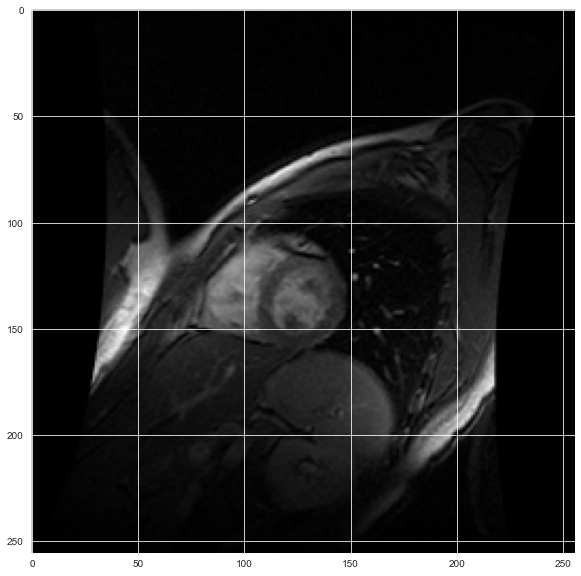

In [40]:
x, y = test_gen.__getitem__(1)
plt.figure(figsize=(20, 10))

plt.imshow(x[0]);
print(x.shape)
print(x[0].shape)
print(y[0])

### Creating The Model

In [41]:
import tensorflow as tf
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3)
)

In [42]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [43]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [44]:
neck = tf.keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)

def build_tower(in_layer):
    neck = tf.keras.layers.Dense(512)(in_layer)
    neck = tf.keras.layers.BatchNormalization()(neck)
    neck = tf.keras.layers.ReLU()(neck)

    return neck

def build_head(name, in_layer):
    return tf.keras.layers.Dense(len(column_name), activation='linear', name=name)(in_layer)
    
output = build_head("cardiac_output", build_tower(neck))

In [45]:
model = tf.keras.Model(
    inputs=pre_trained_model.input,
    outputs=[output],

    name = 'cardiac_InceptionV3'
)

In [46]:
model.summary()

Model: "cardiac_InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
model_architecture_path = "H:/Project Files/1_Heart_segmentation/model/architecture/cardiac_inception_v3.png"
tf.keras.utils.plot_model(model, to_file=model_architecture_path)

In [47]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1,
    min_delta=1e-4
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    min_delta=1e-4,
    restore_best_weights=False
)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.0001):
            print("\nReached 0.0001 loss so cancelling training!")
            self.model.stop_training = True
callback = myCallback()

In [48]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.01),
        loss='mean_absolute_error',
        metrics=[tf.keras.metrics.MeanSquaredError(),
                 tf.keras.metrics.RootMeanSquaredError(),
                 tf.keras.metrics.MeanAbsoluteError(),
                tf.keras.metrics.MeanAbsolutePercentageError(),
                tf.keras.metrics.MeanSquaredLogarithmicError(),
                tf.keras.metrics.CosineSimilarity(axis=1),
                tf.keras.metrics.LogCoshError()]

    )
compile_model(model)

In [20]:
%load_ext tensorboard

In [49]:
import datetime


logdir = "H:/Project Files/1_Heart_segmentation/model/logs/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [50]:
history = model.fit(train_gen,  
                     validation_data=valid_gen,                                                      
                      epochs = 100,
                       verbose = 1,
                      use_multiprocessing=False, 
                     callbacks = [callback,tensorboard_callback,reduce_lr_on_plateau,early_stopping])

Epoch 1/100
 1/63 [..............................] - ETA: 0s - loss: 131.2640 - mean_squared_error: 17519.4375 - root_mean_squared_error: 132.3610 - mean_absolute_error: 131.2640 - mean_absolute_percentage_error: 99.9921 - mean_squared_logarithmic_error: 21.6228 - cosine_similarity: 0.0098 - logcosh: 130.5709WARNING:tensorflow:From C:\Users\usha1\Anaconda3\envs\computer_vision_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
63/63 [==============================] - 91s 1s/step - loss: 49.0170 - mean_squared_error: 4351.4023 - root_mean_squared_error: 65.9652 - mean_absolute_error: 49.0170 - mean_absolute_percentage_error: 37.2548 - mean_squared_logarithmic_error: 1.6057 - cosine_similarity: 0.9761 - logcosh: 48.3329 - val_loss: 104.9797 - val_mean_squared_error: 12864.6875 - val_root_mean_squared_erro

63/63 [==============================] - 28s 445ms/step - loss: 3.0356 - mean_squared_error: 15.0201 - root_mean_squared_error: 3.8756 - mean_absolute_error: 3.0356 - mean_absolute_percentage_error: 2.3350 - mean_squared_logarithmic_error: 8.6927e-04 - cosine_similarity: 0.9998 - logcosh: 2.4296 - val_loss: 4.8019 - val_mean_squared_error: 33.2533 - val_root_mean_squared_error: 5.7666 - val_mean_absolute_error: 4.8019 - val_mean_absolute_percentage_error: 3.7316 - val_mean_squared_logarithmic_error: 0.0019 - val_cosine_similarity: 0.9998 - val_logcosh: 4.1535
Epoch 14/100
63/63 [==============================] - ETA: 0s - loss: 3.0701 - mean_squared_error: 15.0648 - root_mean_squared_error: 3.8813 - mean_absolute_error: 3.0701 - mean_absolute_percentage_error: 2.3620 - mean_squared_logarithmic_error: 8.7682e-04 - cosine_similarity: 0.9998 - logcosh: 2.4613
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
63/63 [==============================] - 28s 451ms/

Epoch 26/100
63/63 [==============================] - 29s 455ms/step - loss: 2.3451 - mean_squared_error: 8.9412 - root_mean_squared_error: 2.9902 - mean_absolute_error: 2.3451 - mean_absolute_percentage_error: 1.8020 - mean_squared_logarithmic_error: 5.1636e-04 - cosine_similarity: 0.9998 - logcosh: 1.7629 - val_loss: 2.1956 - val_mean_squared_error: 8.1389 - val_root_mean_squared_error: 2.8529 - val_mean_absolute_error: 2.1956 - val_mean_absolute_percentage_error: 1.7012 - val_mean_squared_logarithmic_error: 4.8242e-04 - val_cosine_similarity: 0.9998 - val_logcosh: 1.6227
Epoch 27/100
63/63 [==============================] - 28s 449ms/step - loss: 2.2137 - mean_squared_error: 8.0277 - root_mean_squared_error: 2.8333 - mean_absolute_error: 2.2137 - mean_absolute_percentage_error: 1.7034 - mean_squared_logarithmic_error: 4.6639e-04 - cosine_similarity: 0.9998 - logcosh: 1.6380 - val_loss: 2.2020 - val_mean_squared_error: 8.1737 - val_root_mean_squared_error: 2.8590 - val_mean_absolute_

63/63 [==============================] - 29s 456ms/step - loss: 2.1492 - mean_squared_error: 7.6012 - root_mean_squared_error: 2.7570 - mean_absolute_error: 2.1492 - mean_absolute_percentage_error: 1.6530 - mean_squared_logarithmic_error: 4.4055e-04 - cosine_similarity: 0.9999 - logcosh: 1.5771 - val_loss: 2.2255 - val_mean_squared_error: 8.2740 - val_root_mean_squared_error: 2.8765 - val_mean_absolute_error: 2.2255 - val_mean_absolute_percentage_error: 1.7281 - val_mean_squared_logarithmic_error: 4.8861e-04 - val_cosine_similarity: 0.9998 - val_logcosh: 1.6501
Epoch 40/100
63/63 [==============================] - 28s 452ms/step - loss: 2.2355 - mean_squared_error: 8.1478 - root_mean_squared_error: 2.8544 - mean_absolute_error: 2.2355 - mean_absolute_percentage_error: 1.7187 - mean_squared_logarithmic_error: 4.7186e-04 - cosine_similarity: 0.9998 - logcosh: 1.6588 - val_loss: 2.0864 - val_mean_squared_error: 7.4447 - val_root_mean_squared_error: 2.7285 - val_mean_absolute_error: 2.0864

63/63 [==============================] - 29s 454ms/step - loss: 2.1277 - mean_squared_error: 7.4508 - root_mean_squared_error: 2.7296 - mean_absolute_error: 2.1277 - mean_absolute_percentage_error: 1.6318 - mean_squared_logarithmic_error: 4.2788e-04 - cosine_similarity: 0.9999 - logcosh: 1.5570 - val_loss: 2.0772 - val_mean_squared_error: 7.3441 - val_root_mean_squared_error: 2.7100 - val_mean_absolute_error: 2.0772 - val_mean_absolute_percentage_error: 1.6095 - val_mean_squared_logarithmic_error: 4.3615e-04 - val_cosine_similarity: 0.9998 - val_logcosh: 1.5122
Epoch 53/100
63/63 [==============================] - 29s 458ms/step - loss: 2.0247 - mean_squared_error: 6.7517 - root_mean_squared_error: 2.5984 - mean_absolute_error: 2.0247 - mean_absolute_percentage_error: 1.5573 - mean_squared_logarithmic_error: 3.9266e-04 - cosine_similarity: 0.9999 - logcosh: 1.4599 - val_loss: 2.0670 - val_mean_squared_error: 7.2882 - val_root_mean_squared_error: 2.6997 - val_mean_absolute_error: 2.0670

63/63 [==============================] - 29s 455ms/step - loss: 2.0441 - mean_squared_error: 6.9090 - root_mean_squared_error: 2.6285 - mean_absolute_error: 2.0441 - mean_absolute_percentage_error: 1.5751 - mean_squared_logarithmic_error: 4.0234e-04 - cosine_similarity: 0.9999 - logcosh: 1.4784 - val_loss: 2.0479 - val_mean_squared_error: 7.1802 - val_root_mean_squared_error: 2.6796 - val_mean_absolute_error: 2.0479 - val_mean_absolute_percentage_error: 1.5846 - val_mean_squared_logarithmic_error: 4.2542e-04 - val_cosine_similarity: 0.9999 - val_logcosh: 1.4844
Epoch 66/100
63/63 [==============================] - 29s 457ms/step - loss: 2.0491 - mean_squared_error: 6.9449 - root_mean_squared_error: 2.6353 - mean_absolute_error: 2.0491 - mean_absolute_percentage_error: 1.5745 - mean_squared_logarithmic_error: 4.0099e-04 - cosine_similarity: 0.9999 - logcosh: 1.4830 - val_loss: 2.0452 - val_mean_squared_error: 7.1550 - val_root_mean_squared_error: 2.6749 - val_mean_absolute_error: 2.0452

### Saving Model

In [51]:
model_path = "H:/Project Files/1_Heart_segmentation/model/inception_v3"
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: H:/Project Files/1_Heart_segmentation/model/inception_v3\assets


### Prediction Test Data

In [52]:
predicted_vals = model.predict_generator(test_gen, steps = len(test_gen))

Instructions for updating:
Please use Model.predict, which supports generators.


In [53]:
predicted_vals.shape

(502, 128)

### Visualizing Predictions

In [60]:
dim = (256,256)
image_path = "H:/Project Files/1_Heart_segmentation/Images/"
def visualize_prediction(df,preds):    
    names = df['id']
    dots_true = df[column_name].to_numpy()
    dots_pred  = preds
    
    for i in range(0,10):
        img = cv2.imread(image_path+names[i],-1)
        picture  = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        fig, ax = plt.subplots(1,4,  figsize=(30,20))
        
        ax[0].grid(False)
        ax[0].imshow(picture, cmap='gray')
        
        #Unprocessed Label
        pointsXendo_true = dots_true[i,:32]
        pointsYendo_true = dots_true[i,32:64]

        pointsXepi_true = dots_true[i,64:96]
        pointsYepi_true = dots_true[i,96:128]

        last_x_points = []
        last_x_points.append(pointsXendo_true[0])
        last_x_points.append(pointsXendo_true[31])

        last_y_points = []
        last_y_points.append(pointsYendo_true[0])
        last_y_points.append(pointsYendo_true[31])



        ax[1].grid(False)
        ax[1].imshow(picture, cmap='gray')        
        ax[1].plot(pointsXendo_true,pointsYendo_true,last_x_points,last_y_points, color='green')
        
        last_x_points = []
        last_x_points.append(pointsXepi_true[0])
        last_x_points.append(pointsXepi_true[31])

        last_y_points = []
        last_y_points.append(pointsYepi_true[0])
        last_y_points.append(pointsYepi_true[31])
        ax[1].plot(pointsXepi_true,pointsYepi_true,last_x_points,last_y_points, color='red')
        
        #True
        
        pointsXendo_true = dots_true[i,:32]
        pointsYendo_true = dots_true[i,32:64]

        pointsXepi_true = dots_true[i,64:96]
        pointsYepi_true = dots_true[i,96:128]

        stemp1 = pointsXendo_true.shape[0]

        a1 = np.linspace(0, 10, num=stemp1, retstep=False)
        sampling_data_endo_true=np.zeros((1000,2))
        sampling_data_epi_true=np.zeros((1000,2))
        b1 = np.linspace(0, 10, num=1000, retstep=False)

        sampling_data_endo_true[:,0] = interpolate.PchipInterpolator(a1, pointsXendo_true)(b1)
        sampling_data_endo_true[:,1] = interpolate.PchipInterpolator(a1, pointsYendo_true)(b1)
        sampling_data_epi_true[:,0] = interpolate.PchipInterpolator(a1, pointsXepi_true)(b1)
        sampling_data_epi_true[:,1] = interpolate.PchipInterpolator(a1, pointsYepi_true)(b1)

        dots = sampling_data_endo_true
        last_x_points = []
        last_x_points.append(dots[0,0])
        last_x_points.append(dots[999,0])

        last_y_points = []
        last_y_points.append(dots[0,1])
        last_y_points.append(dots[999,1])
        
        ax[2].grid(False)
        ax[2].imshow(picture, cmap='gray')
        ax[2].plot(dots[:,0],dots[:,1],last_x_points,last_y_points, color='green')



        dots = sampling_data_epi_true
        last_x_points = []
        last_x_points.append(dots[0,0])
        last_x_points.append(dots[999,0])

        last_y_points = []
        last_y_points.append(dots[0,1])
        last_y_points.append(dots[999,1])
        
        
        ax[2].plot(dots[:,0],dots[:,1],last_x_points,last_y_points, color='red')
        
        
        #Predicted
        
        pointsXendo_pred = dots_pred[i,:32]
        pointsYendo_pred = dots_pred[i,32:64]

        pointsXepi_pred = dots_pred[i,64:96]
        pointsYepi_pred = dots_pred[i,96:128]

        stemp1 = pointsXendo_pred.shape[0]

        a1 = np.linspace(0, 10, num=stemp1, retstep=False)
        sampling_data_endo_pred=np.zeros((1000,2))
        sampling_data_epi_pred=np.zeros((1000,2))
        b1 = np.linspace(0, 10, num=1000, retstep=False)

        sampling_data_endo_pred[:,0] = interpolate.PchipInterpolator(a1, pointsXendo_pred)(b1)
        sampling_data_endo_pred[:,1] = interpolate.PchipInterpolator(a1, pointsYendo_pred)(b1)
        sampling_data_epi_pred[:,0] = interpolate.PchipInterpolator(a1, pointsXepi_pred)(b1)
        sampling_data_epi_pred[:,1] = interpolate.PchipInterpolator(a1, pointsYepi_pred)(b1)

        dots = sampling_data_endo_pred
        last_x_points = []
        last_x_points.append(dots[0,0])
        last_x_points.append(dots[999,0])

        last_y_points = []
        last_y_points.append(dots[0,1])
        last_y_points.append(dots[999,1])
        
        ax[3].grid(False)
        ax[3].imshow(picture, cmap='gray')
        ax[3].plot(dots[:,0],dots[:,1],last_x_points,last_y_points, color='green')



        dots = sampling_data_epi_pred
        last_x_points = []
        last_x_points.append(dots[0,0])
        last_x_points.append(dots[999,0])

        last_y_points = []
        last_y_points.append(dots[0,1])
        last_y_points.append(dots[999,1])

        
        ax[3].plot(dots[:,0],dots[:,1],last_x_points,last_y_points, color='red')


In [61]:
test_df = test_df.reset_index(drop= True)


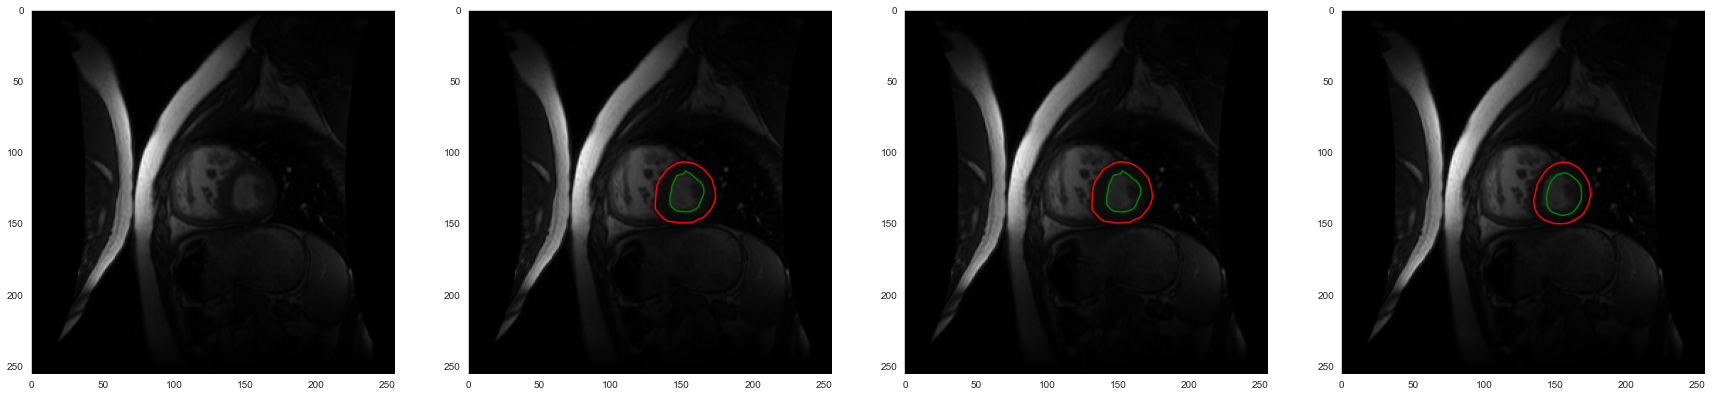

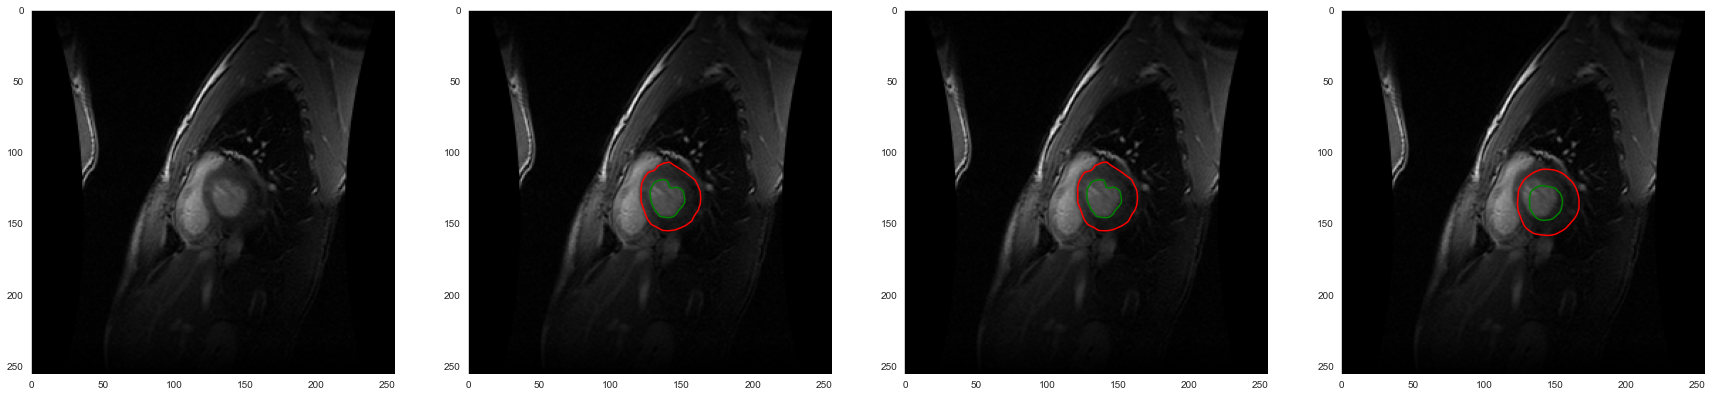

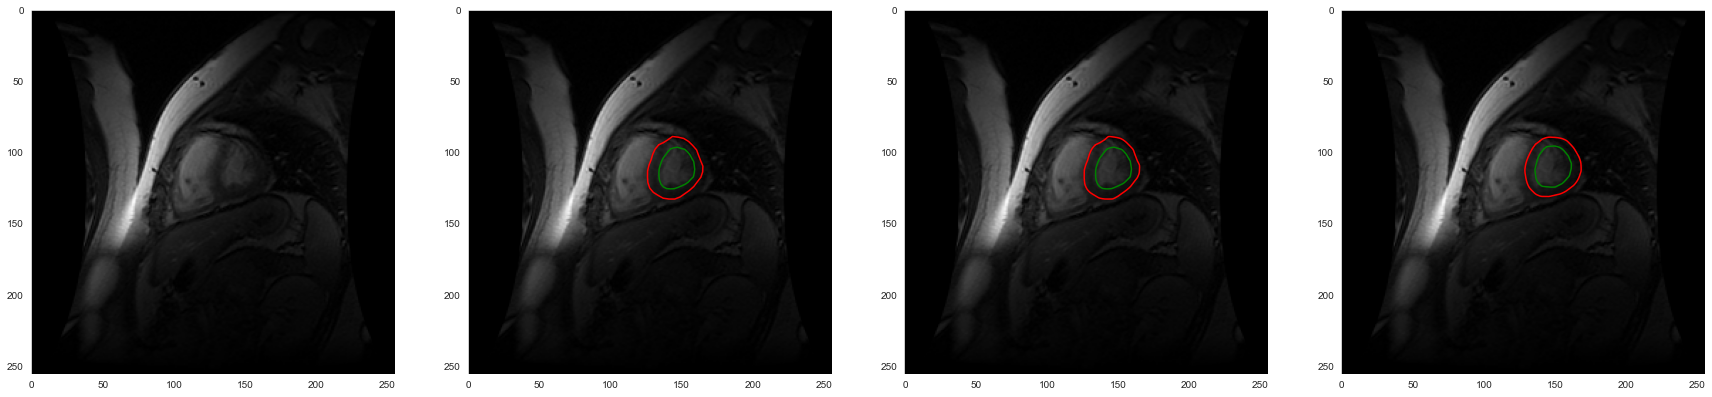

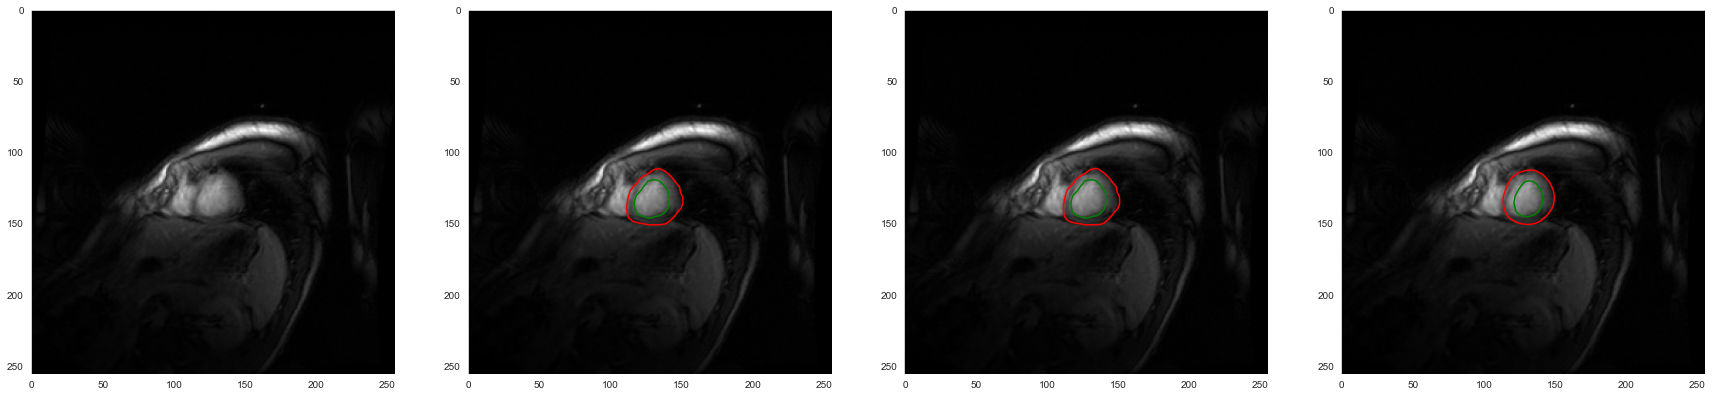

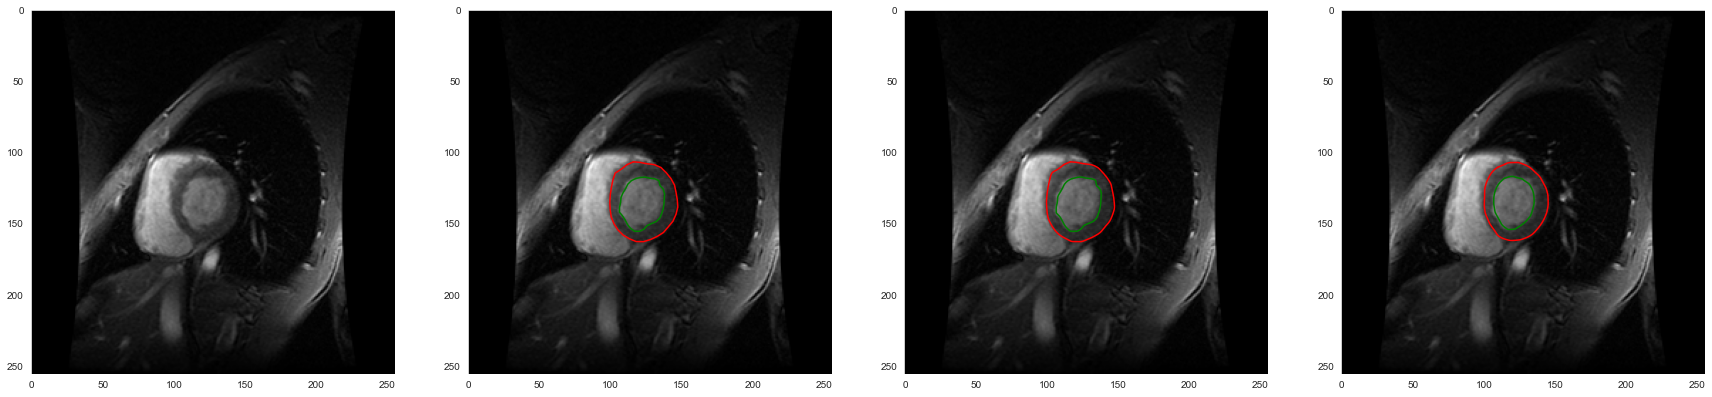

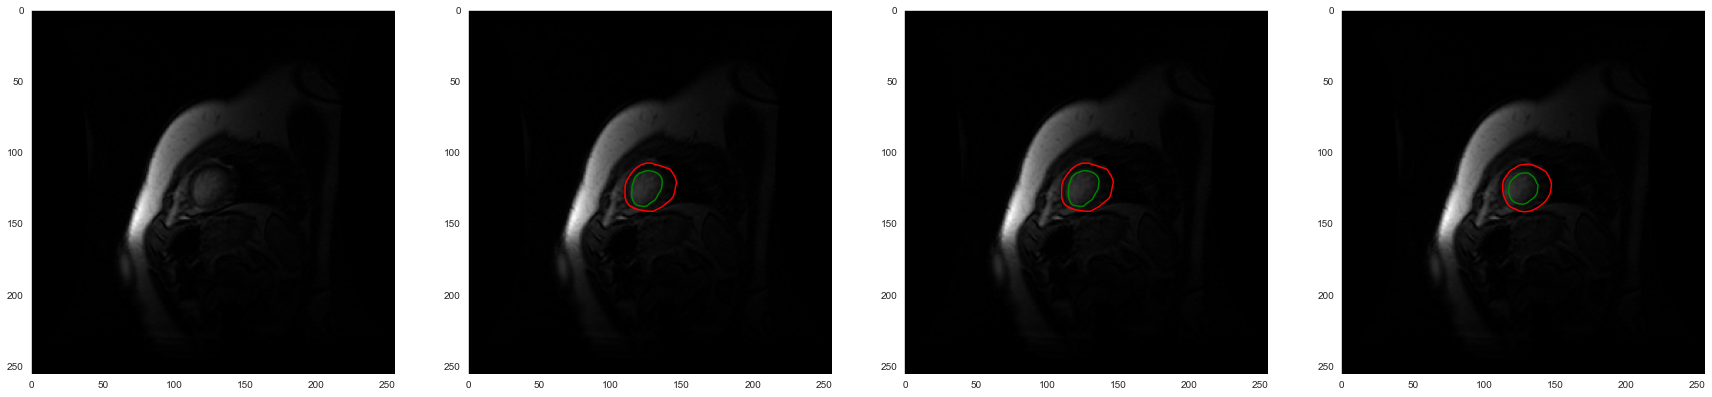

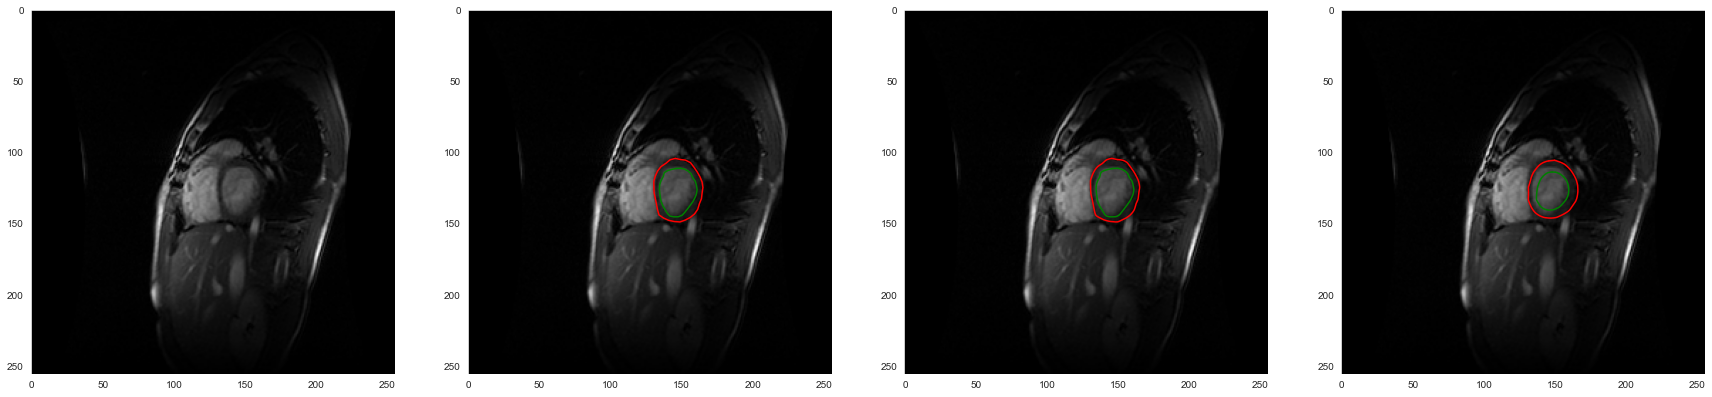

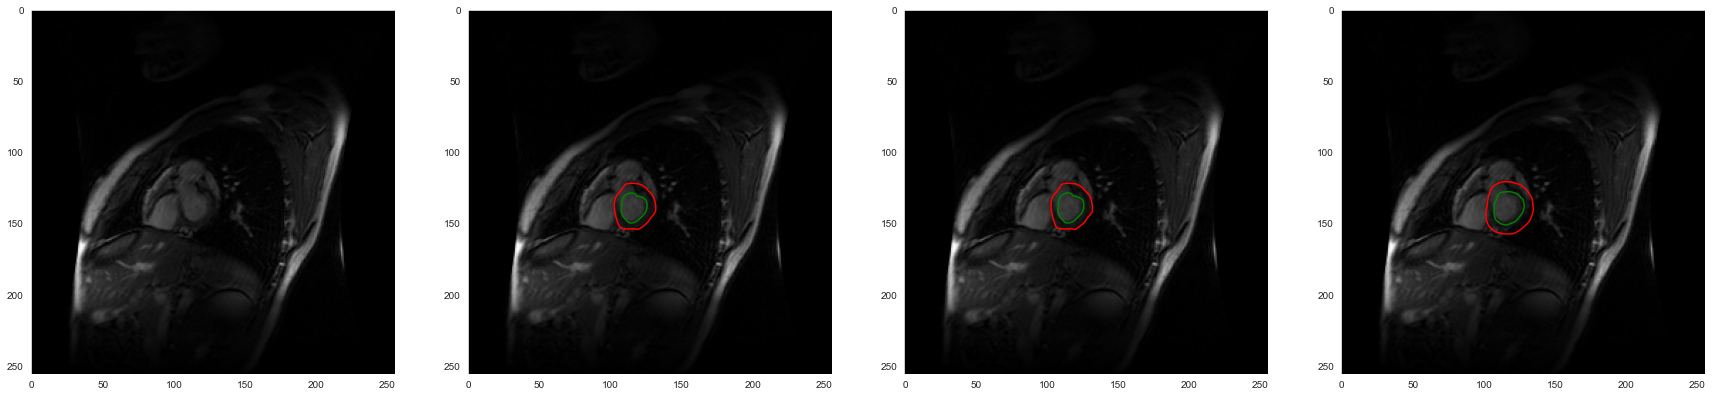

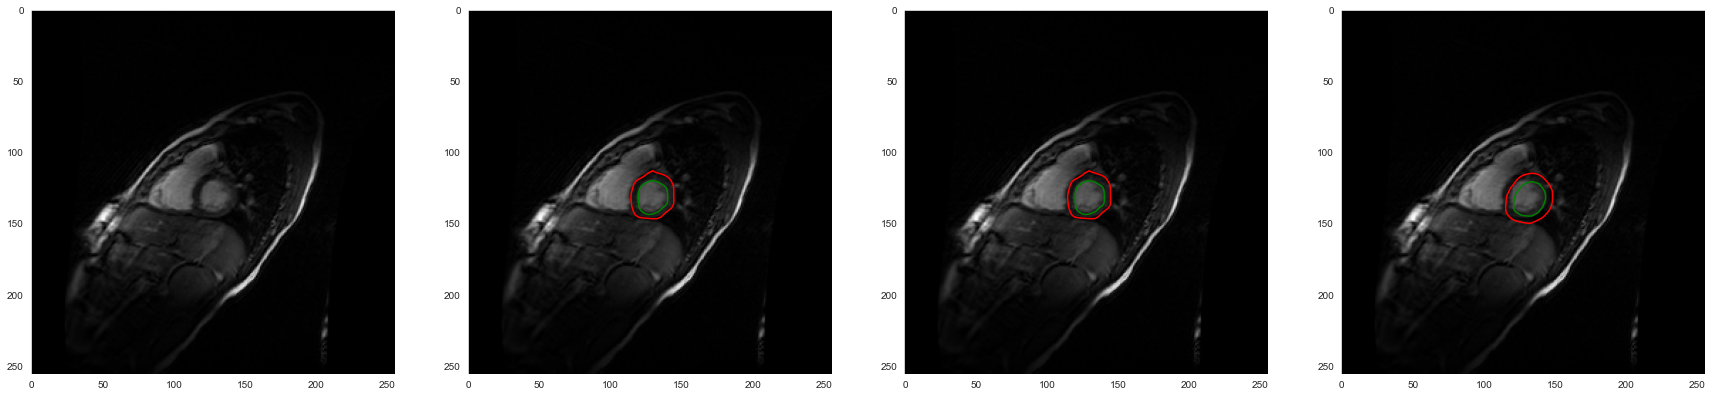

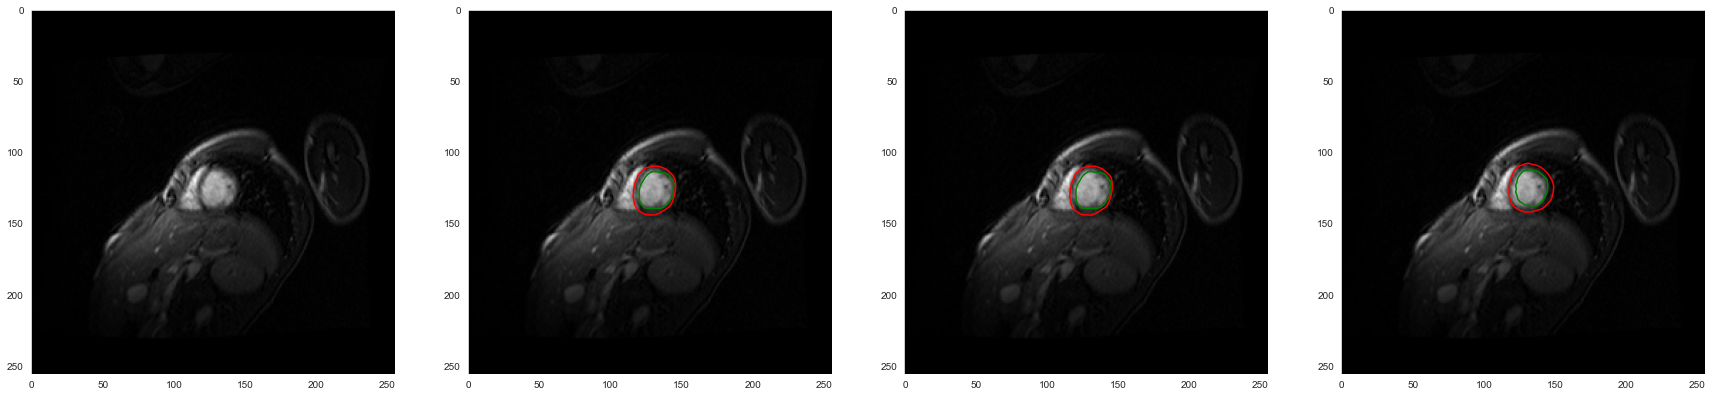

In [62]:
visualize_prediction(test_df,predicted_vals)

In [63]:
model.evaluate(test_gen, steps = len(test_gen))

8/8 [==============================] - 2s 295ms/step - loss: 2.0193 - mean_squared_error: 7.0579 - root_mean_squared_error: 2.6567 - mean_absolute_error: 2.0193 - mean_absolute_percentage_error: 1.5649 - mean_squared_logarithmic_error: 4.1750e-04 - cosine_similarity: 0.9999 - logcosh: 1.4593


[2.019252061843872,
 7.057904243469238,
 2.6566717624664307,
 2.019252061843872,
 1.564854383468628,
 0.00041749721276573837,
 0.9998665452003479,
 1.459343671798706]